In [ ]:
#Simple notebook to do PCA on SDSS spectra and galaxy images.

#Author: Viviana Acquaviva (license: BSD), see also other sources.

In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from sklearn import preprocessing
%matplotlib inline

import skimage
from skimage.transform import resize, rescale
from skimage import io

### Dimensionality Reduction

In [10]:
from sklearn import decomposition

Principal Component Analysis (PCA) and similar algorithms are used for dimensionality reduction in data-intensive sciences. It finds the most interesting linear combinations of attributes, so that high-dimensional data can be visualized in a 2D or 3D plot. Scikit-learn has methods to compute PCA and several variants. Classic PCA has tough complexity $\mathcal{O}[N^3].$ 

Let's look at an example from 

https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/dimensionality_reduction.html#sdss-spectral-data

In [2]:
data = np.load('spec4000_corrected.npz')

In [3]:
wavelengths = data['wavelengths']
X = data['X']
y = data['y']
labels = data['labels'].astype('str')

In [4]:
X.shape

(4000, 1000)

In [5]:
y

array([4, 3, 3, ..., 4, 2, 4], dtype=int32)

In [6]:
labels

array(['unknown', 'star', 'absorption galaxy', 'galaxy',
       'emission galaxy', 'narrow-line QSO', 'broad-line QSO', 'sky',
       'Hi-z QSO', 'Late-type star'], dtype='<U17')

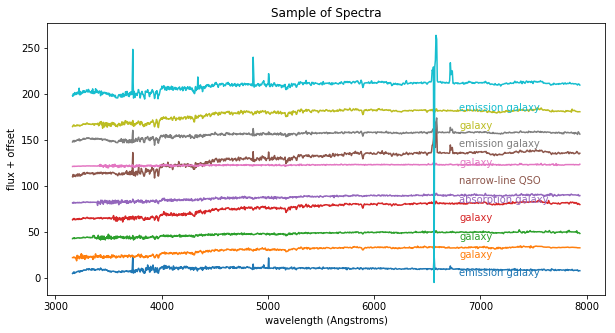

In [7]:
#We can plot a bunch of examples

plt.figure(figsize=(10,5))

for i in range(10):
    l = plt.plot(wavelengths, X[i] + 20 * i)
    c = l[0].get_color()
    plt.text(6800, 2 + 20 * i, labels[y[i]], color=c)

plt.subplots_adjust(hspace=0)
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('flux + offset')
plt.title('Sample of Spectra');

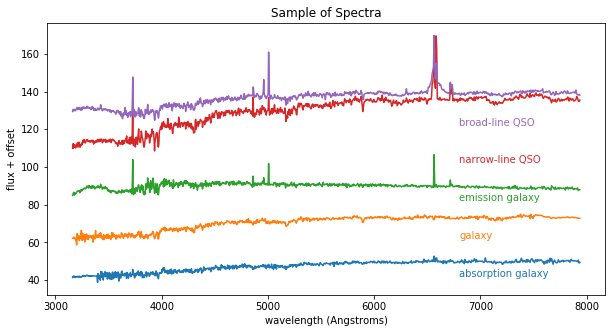

In [8]:
#And some more representative examples

plt.figure(figsize=(10,5))

for i_class in (2, 3, 4, 5, 6):
    i = np.where(y == i_class)[0][0]
    l = plt.plot(wavelengths, X[i] + 20 * i_class)
    c = l[0].get_color()
    plt.text(6800, 2 + 20 * i_class, labels[i_class], color=c)

plt.subplots_adjust(hspace=0)
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('flux + offset')
plt.title('Sample of Spectra');

In [11]:
#  Perform PCA

X = preprocessing.normalize(X)

pca = decomposition.PCA(n_components=50, random_state=0)

X_proj = pca.fit_transform(X)


In [12]:
X_proj.shape

(4000, 50)

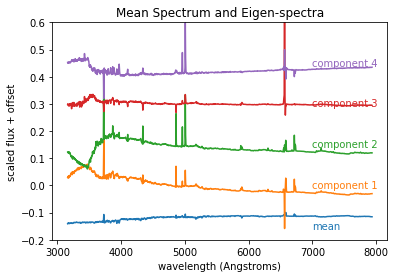

In [13]:
#----------------------------------------------------------------------
#
#  plot PCA eigenspectra
#

plt.figure()

l = plt.plot(wavelengths, pca.mean_ - 0.15)
c = l[0].get_color()
plt.text(7000, -0.16, "mean", color=c)

for i in range(4):
    l = plt.plot(wavelengths, pca.components_[i] + 0.15 * i)
    c = l[0].get_color()
    plt.text(7000, -0.01 + 0.15 * i, "component %i" % (i + 1), color=c)
plt.ylim(-0.2, 0.6)
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('scaled flux + offset')
plt.title('Mean Spectrum and Eigen-spectra')

plt.show()


We can interpret the eigenvectors as the "basis" that explains most of the variability in the data. Therefore, these methods are useful not only to reduce the size of the data set, but also to build intuition on the most important features.

How can we know if this works? Let's reverse-engineer the process:

In [14]:
Xrec = pca.inverse_transform(X_proj)

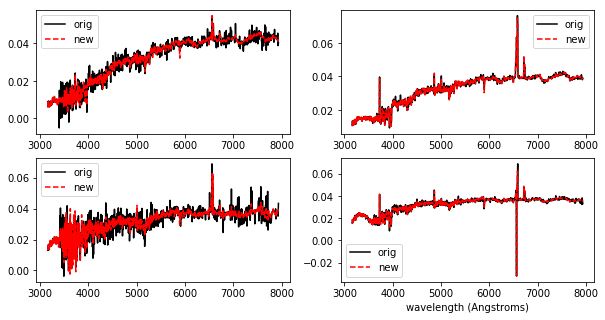

In [16]:
plt.figure(figsize=(10,5))

for i in range(4,8):
    plt.subplot(2,2,i-3)
    plt.plot(wavelengths, X[i], label = 'orig', c = 'k')
    plt.plot(wavelengths, Xrec[i], '--', label = 'new', c = 'r')
    plt.legend()
plt.xlabel('wavelength (Angstroms)');


To get an idea of the ideal number, we can plot the "explained_variance_ratio" property of the PCA decomposition.

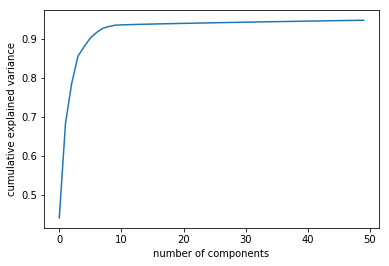

In [17]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Let's now take a look at images.

In [18]:
#Takes < 1 minute, let's use non-bubbled images

images = []
for i in range(200):
    img =skimage.io.imread('Image_'+str(i)+'.png')
    img_resized = resize(img,(100,100))
    length = np.prod(img_resized.shape)
    img_resized = np.reshape(img_resized,length)
    images.append(img_resized)
    
images = np.vstack(images)

I did it on the RGB channels separately. I'm not sure if it's optimal!

In [19]:
r_images = images.reshape(200, -1,  3)[:,:,0]

In [20]:
r_images.shape

(200, 10000)

In [21]:
#Calling PCA on images

estimator = decomposition.PCA(n_components=100)                       
r_images_PCA = estimator.fit_transform(r_images)

In [22]:
#This tell us about the dimensionality reduction we have achieved.

r_images_PCA.shape

(200, 100)

In [23]:
components = estimator.components_

We can plot the first 50 components.

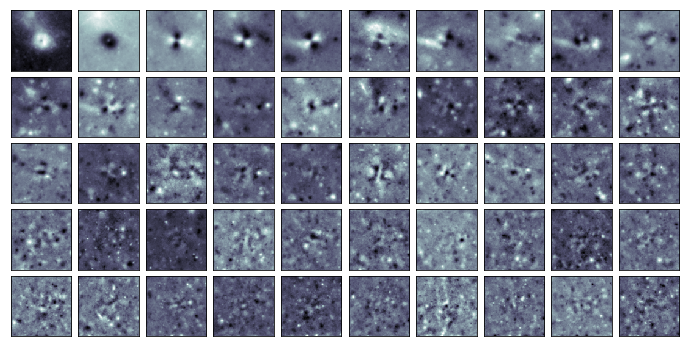

In [24]:
fig, axes = plt.subplots(5, 10, figsize=(12, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow((estimator.components_[i].reshape(100, 100)), cmap='bone')

We can see here if we see an obvious optimal number of components.

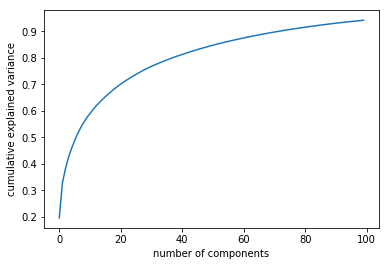

In [25]:
plt.plot(np.cumsum(estimator.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Let's now reconstruct the original images.

In [26]:
r_projected = estimator.inverse_transform(r_images_PCA)

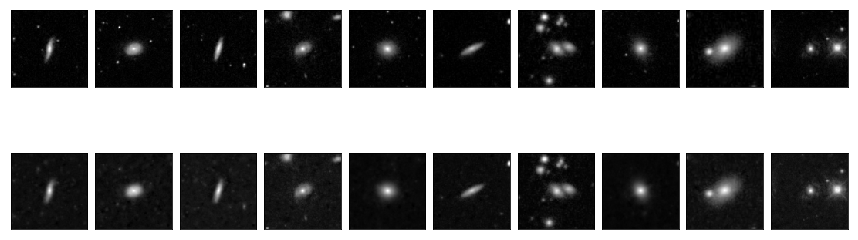

In [27]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(15, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(r_images[i].reshape(100, 100), cmap='gray')
    ax[1, i].imshow(r_projected[i].reshape(100, 100), cmap='gray')

We can do it for the three channels at once and then join them together:

In [28]:
estimator = decomposition.PCA(n_components=100) 

r_images = images.reshape(200, -1,  3)[:,:,1]                     
estimator.fit(r_images)
r_images_PCA = estimator.fit_transform(r_images)
r_projected = estimator.inverse_transform(r_images_PCA)

g_images = images.reshape(200, -1,  3)[:,:,1]                     
estimator.fit(g_images)
g_images_PCA = estimator.fit_transform(g_images)
g_projected = estimator.inverse_transform(g_images_PCA)

b_images = images.reshape(200, -1,  3)[:,:,2]                     
estimator.fit(b_images)
b_images_PCA = estimator.fit_transform(b_images)
b_projected = estimator.inverse_transform(b_images_PCA)

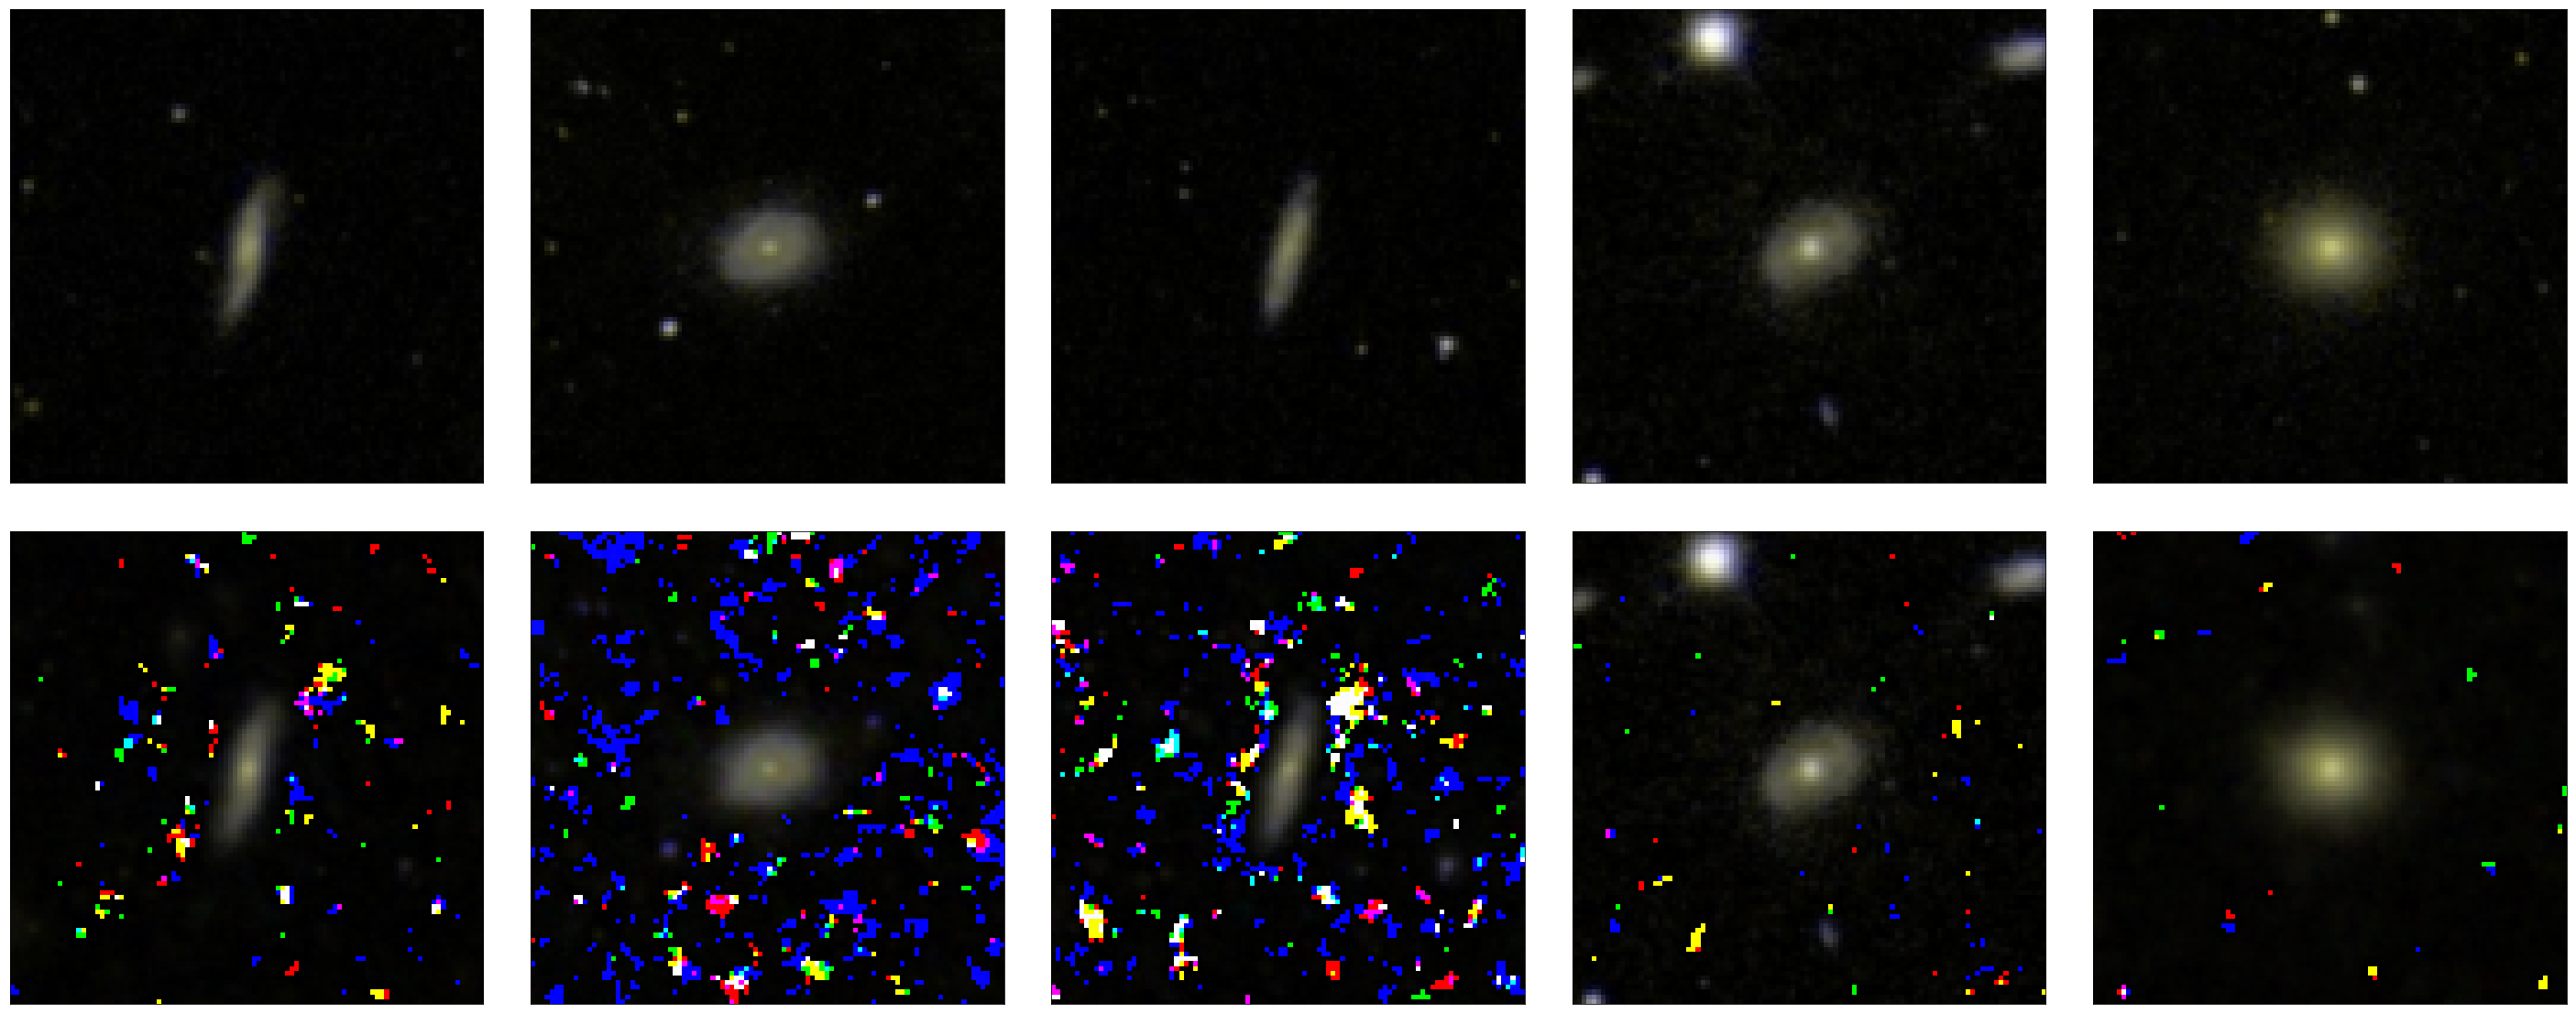

In [30]:
# Plot the results
fig, ax = plt.subplots(2, 5, figsize=(50, 20),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(5):
    ax[0, i].imshow((np.dstack([r_images[i].reshape(100, 100)*255, g_images[i].reshape(100, 100)*255, 
        b_images[i].reshape(100,100)*255]).astype(np.uint8)))
    ax[1, i].imshow((np.dstack([r_projected[i].reshape(100, 100)*255, g_projected[i].reshape(100, 100)*255, 
        b_projected[i].reshape(100,100)*255]).astype(np.uint8)))

## Conclusions

Dimensionality reduction techniques are useful both to build understanding of what's in the data and to make sizes more manageable.

Im many cases, it can be used as a pre-processing step for clustering analyses. For example in the Example # 2 of:

https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb

Some nonlinear techniques (e.g. Kernel PCA, t-SNE, SOM...) are better at capturing the variance.

See for example:

https://scikit-learn.org/stable/modules/manifold.html#manifold

